## This Book Conducts Semantic Analysis on speaker using cosine similarity 

In [1]:
#import libraries
#reading api key
from dotenv import dotenv_values
#reading data 
import pandas as pd
#data preprocessing
import re
import numpy as np
from transformers import BertModel, BertTokenizer 
import textwrap
#vector embedding 
import torch
#clustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
#topic generation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from openai import OpenAI
import networkx as nx


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import openai credentials 
config = dotenv_values('credential.env')
openai_key = config['openai_api_key']
openai_deployment_name = "gpt-4"


In [3]:
df = pd.read_csv('Session_one/all_meeting_merged.csv')
df.head()

,Id,Session,Meeting,Speaker,Text
0,S1M11,1,1,﻿Chairman,Excellencies. I am pleased to declare the firs...
1,S1M12,1,1,Chile,Before going to the logistics and the backgrou...
2,S1M13,1,1,Russia,"Thank you, Mr. President. I will now ask for t..."
3,S1M14,1,1,Chairman,Thank you for your attention. I thank the repr...
4,S1M15,1,1,Cuba,"Cuba representative, please. Thank you, Presid..."


In [4]:
#remove all rows with "Chairman" in the speaker column and store in a new df
df_updated = df[df['Speaker'] != 'Chairman']
#get the number of rows
print(f' number of rows is {df_updated.shape[0]}')

 number of rows is 672


In [5]:
# Delete row where 'speaker' column contains a specific string
df_updated = df_updated[df_updated['Speaker'] != '\ufeffChairman']

In [6]:
# Get row where 'Speaker' column contains the specified string
df_updated = df_updated[df_updated['Speaker'] != 'thank you, Mr. President, and thank you, dear German delegate, for this question. I hope I understood it correctly. To what extent, as far as I understand, you asked this question. The Chekhov Convention and other agreements have a position that interact and that rely on each other or are restricted from each other. This is related to understanding the articles in this agreement. I am assuming that... in order to... well, in the space agreement it is based on the usual international law and many positions coincide with the positions of other agreements and agreements. But it is a little more limited. And of course, as it is the Chekhov Convention, the right to space is based on the Chekhov Convention. Chairman']


In [7]:
# Delete rows where 'speaker' column contains any of the specified values
df_updated = df_updated[~df_updated['Speaker'].isin(['00:09:47', '00:34:06', '00:26:15','NAROOJ','Dr. Suzuki', 'Mr. James Black', 'Professor Wang' ,'Mr. Clinton Clark','Professor Kazuto Suzuki',
 'Mr. Black','Doctor Bowen', 'Doctor Gregor.', 'Mr. Stefanovich' ,'Doctor Gregor', 'Mr. Bertolotti', 'Mr. Vignetti',
 'Miss. Elena Mozarova', '00:45:20' ,'Miss Elina Morozova', 'Mr. Lena Morozova' ,'Mr. Moto Vinati' ,'01:39:45' ,'Miss Alina Morozova'
 'Mr. Mauro Vignetti', 'Mr. David Bertolotti','Doctor Bown', 'Doctor Brown', 'Mr. Dimitri Stefanovic', 'Doctor Grego' ,'Doctor. Bone', 'Mr. Stefanovic','Miss Alina Morozova' ,'Mr. Mauro Vignetti', 'Chairma'])]

In [8]:
# Replace specific values in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['Russian Federation', 'The Russian Federation','the Russian Federation'], 'Russia')

In [9]:
# Replace specific values in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The United States', 'USA'], 'United States')

In [10]:
# Replace specific values in the 'speaker' column
df_updated['Speaker'] = df_updated['Speaker'].replace(['The United Kingdom', 'UK'], 'United Kingdom')

In [21]:
# Print all unique values in the 'speaker' column
print(df_updated['Speaker'].unique())

['Chile' 'Russia' 'Cuba' 'Geneva' 'United Nation' 'Japan' 'France'
 'Russian' 'Mexico' 'Austria' 'United States' 'India' 'Portugal' 'Couplot'
 'Canada' 'Secretary' 'Hong' 'China' 'European Union' 'Turkey' 'French'
 'Germany' 'United Kingdom' 'Sri Lanka' 'President' 'Portuguese'
 'Netherlands' 'Italy' 'Argentine' 'Sri Lanks' 'United Arab' 'Switzerland'
 'Brazil' 'Polish' 'Iran' 'New Zealand' 'Israel' 'Indonesian' 'Chechen'
 'Australia' 'Finland' 'Venezuela' 'Algeria' 'Korea' 'United Nations'
 'Mississippi.' 'Mississippi' 'Askara' 'Askarta' 'Sweden' 'Spain'
 'Oskarot' 'Pakistan' 'Indonesia' 'Oskar' 'Philippines'
 'Secure World Foundation' 'Stockholm' 'South Africa' 'Martinez' 'Uruguay'
 'Mr. Clark' 'Unidir' 'Cambodia' 'Norway' 'The Republic of Korea'
 'The Secure World Foundation'
 'The Australian Center for Space Governance' 'Belgium' 'Egypt' 'Ireland'
 'Saudi Arabia' 'ICRC' 'Poland' 'The Observer Research Foundation'
 'The Hillasa Center Institute of Physics of the Czech Academy of Sci

In [22]:
def chunk_text(row):
    text = row['Text']
    if len(text) > 3500:
        return textwrap.wrap(text, 3000)
    else:
        return [text]



In [23]:
#data cleaning 
def updated_text(text):
    #merge hyphanated words
    text = text.replace(' - ', '')
    #delete hyphens
    text = text.replace('-', '')
    #merge all words that have anti preceeding it with anti
    text  = re.sub(r'anti (\w+)', r'anti\1', text)
    text = text.replace('.', ' .')
    text = text.replace(',', ' ,')
    return text

In [24]:
# remove stop words from a custom list of stop words
stopwords = ['the', 'a', 'an', 'and', 'but', 'if', 'or', 'because', 'as', 
             'what', 'which', 'this', 'that', 'these', 'those', 'then', 
             'just', 'so', 'than', 'such', 'both', 'through', 'about', 
             'for', 'is', 'of', 'while', 'during', 'to', 'What', 'Which', 
             'Is', 'If', 'While', 'This', 'we','mr.', 'mr','chairman','chair', 'chairperson','thank', 'you','chairman.''president','floor']


def remove_stopwords(text):
    #convert to lowercase
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stopwords)
    return text


In [25]:
df_updated['Text'] = df_updated.apply(chunk_text, axis=1)
df_updated = df_updated.explode('Text').reset_index(drop=True)
df_updated['cleaned_text'] = df_updated['Text'].apply(updated_text)
df_updated['cleaned_text'] = df_updated['cleaned_text'].apply(remove_stopwords)
df_updated.head()

,Id,Session,Meeting,Speaker,Text,cleaned_text
0,S1M12,1,1,Chile,Before going to the logistics and the backgrou...,"before going logistics background our work , i..."
1,S1M12,1,1,Chile,was created under the resolution of the Genera...,was created under resolution general assembly ...
2,S1M13,1,1,Russia,"Thank you, Mr. President. I will now ask for t...",", . president . i will now ask . on have propo..."
3,S1M15,1,1,Cuba,"Cuba representative, please. Thank you, Presid...","cuba representative , please . , president . i..."
4,S1M16,1,1,Geneva,"Thank you, Mr. President. And once again, I we...",", . president . once again , i welcome geneva ..."


In [26]:
max_length_df = df['Text'].str.len().max()
max_length_df

20322

In [27]:
max_length = df_updated['cleaned_text'].str.len().max()
max_length

3126

In [18]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  # You can replace it with any other BERT model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [30]:
def generate_contextual_embedding(text):
    # Tokenize input text and enforce maximum sequence length
    input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    # Generate contextual embeddings
    with torch.no_grad():
        outputs = model(input_ids)
        # Extract contextual embeddings from the last layer
        last_hidden_states = outputs.last_hidden_state
    # Average pooling over tokens to get a single vector representation
    contextual_embedding = torch.mean(last_hidden_states, dim=1).squeeze().numpy()
    return contextual_embedding


In [31]:
# Compute contextual embeddings for each document
df_updated['contextual_embedding'] = df_updated['cleaned_text'].apply(generate_contextual_embedding)


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [32]:
df_updated.head()

,Id,Session,Meeting,Speaker,Text,cleaned_text,contextual_embedding
0,S1M12,1,1,Chile,Before going to the logistics and the backgrou...,"before going logistics background our work , i...","[-0.33471993, 0.14523645, 0.550925, -0.1534472..."
1,S1M12,1,1,Chile,was created under the resolution of the Genera...,was created under resolution general assembly ...,"[-0.14098798, 0.13639031, 0.47316414, -0.04468..."
2,S1M13,1,1,Russia,"Thank you, Mr. President. I will now ask for t...",", . president . i will now ask . on have propo...","[-0.07558263, 0.20583832, 0.50613683, 0.012809..."
3,S1M15,1,1,Cuba,"Cuba representative, please. Thank you, Presid...","cuba representative , please . , president . i...","[-0.28310287, -0.0080440175, 0.5415721, -0.083..."
4,S1M16,1,1,Geneva,"Thank you, Mr. President. And once again, I we...",", . president . once again , i welcome geneva ...","[0.23916075, 0.17552905, 0.59892267, 0.1302638..."


In [42]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    cosine_similarity = dot_product / (norm_vector1 * norm_vector2)
    return cosine_similarity


In [43]:
# Compute cosine similarity matrix
contextual_embeddings = np.stack(df_updated['contextual_embedding'].to_numpy())
cosine_sim_matrix = np.array([[cosine_similarity(embedding1, embedding2) for embedding2 in contextual_embeddings] for embedding1 in contextual_embeddings])


In [44]:
# Perform Spectral Clustering
n_clusters = 5
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
cluster_labels = spectral_clustering.fit_predict(cosine_sim_matrix)



In [45]:
# Add cluster labels to the original DataFrame
df_updated['cluster_label'] = cluster_labels
df_updated.head()

,Id,Session,Meeting,Speaker,Text,cleaned_text,contextual_embedding,cluster_label
0,S1M12,1,1,Chile,Before going to the logistics and the backgrou...,"before going logistics background our work , i...","[-0.33471993, 0.14523645, 0.550925, -0.1534472...",4
1,S1M12,1,1,Chile,was created under the resolution of the Genera...,was created under resolution general assembly ...,"[-0.14098798, 0.13639031, 0.47316414, -0.04468...",2
2,S1M13,1,1,Russia,"Thank you, Mr. President. I will now ask for t...",", . president . i will now ask . on have propo...","[-0.07558263, 0.20583832, 0.50613683, 0.012809...",2
3,S1M15,1,1,Cuba,"Cuba representative, please. Thank you, Presid...","cuba representative , please . , president . i...","[-0.28310287, -0.0080440175, 0.5415721, -0.083...",4
4,S1M16,1,1,Geneva,"Thank you, Mr. President. And once again, I we...",", . president . once again , i welcome geneva ...","[0.23916075, 0.17552905, 0.59892267, 0.1302638...",2


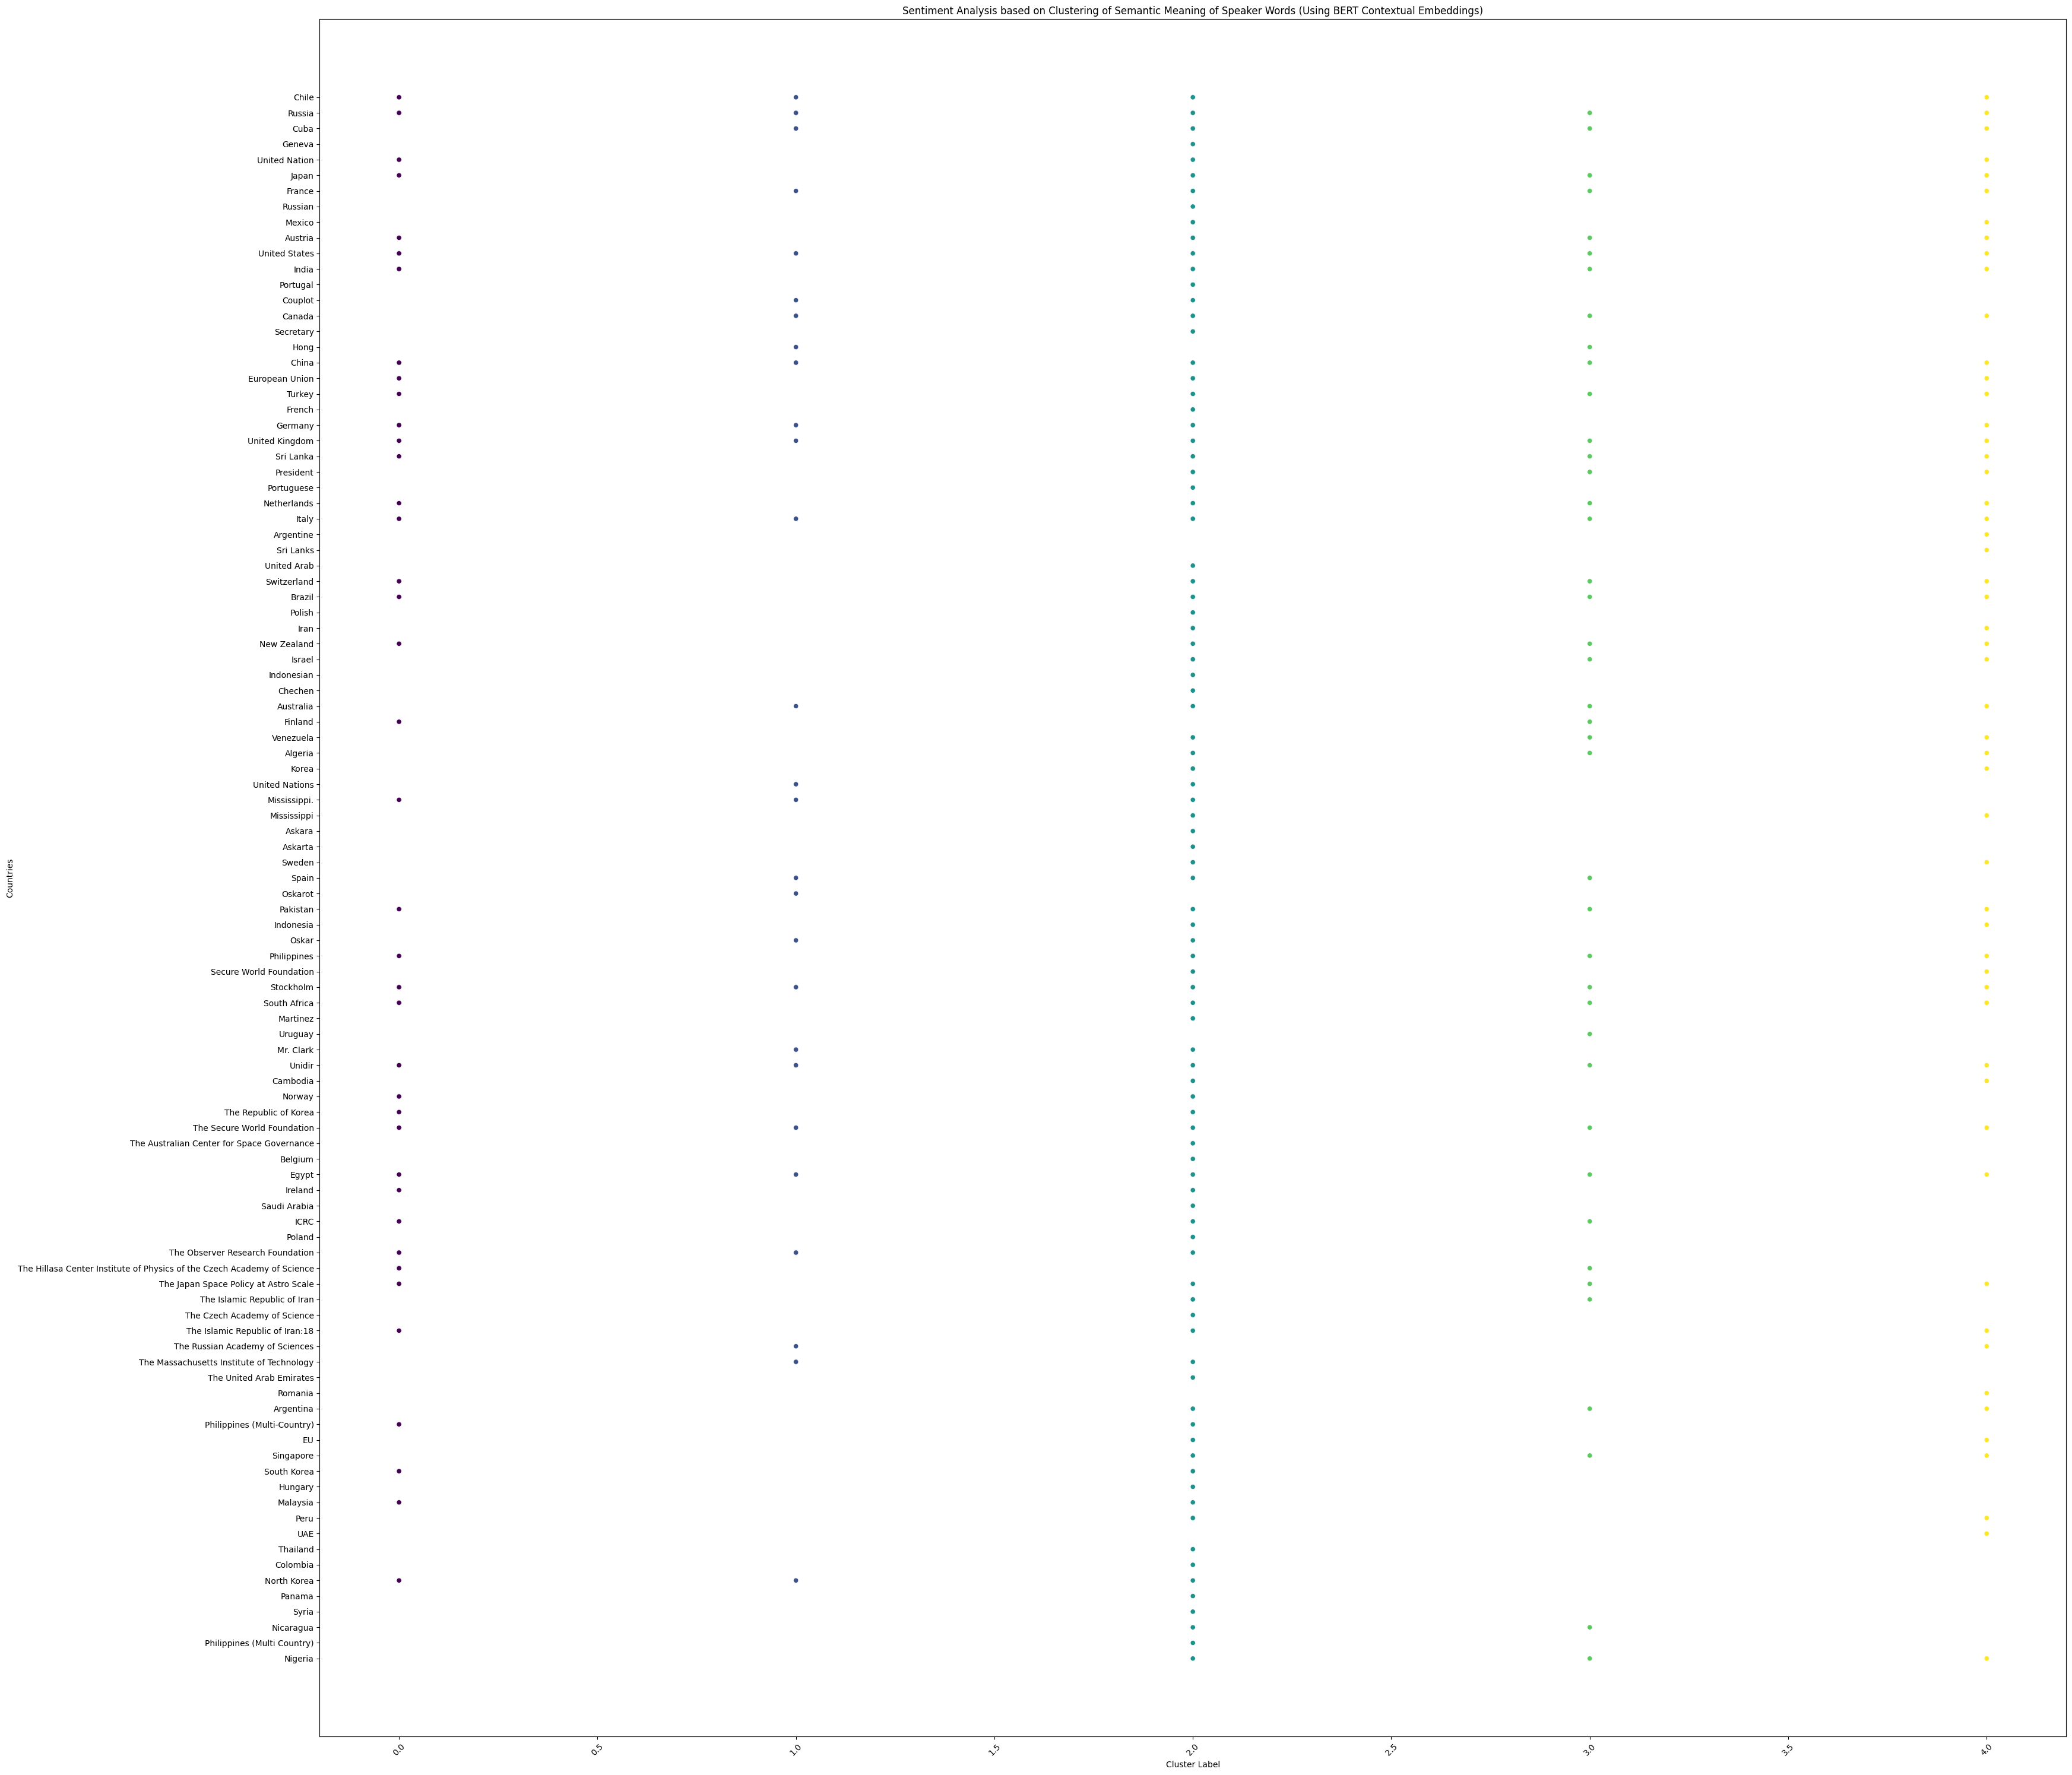

In [46]:
# Visualize the clustering results
plt.figure(figsize=(35, 30))
sns.scatterplot(data=df_updated, x='cluster_label', y='Speaker', hue='cluster_label', palette='viridis', legend=False)
plt.title('Sentiment Analysis based on Clustering of Semantic Meaning of Speaker Words (Using BERT Contextual Embeddings)')
plt.xticks(rotation=45)
plt.xlabel('Cluster Label')
plt.ylabel('Countries')
plt.tight_layout()
plt.show()

In [47]:
# Function to conduct topic modeling on a cluster
def conduct_topic_modeling(cluster_data):
    # Extract text data for the cluster
    cluster_text = cluster_data['cleaned_text'].values
    
    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(cluster_text)
    
    # Apply Non-negative Matrix Factorization (NMF) for topic modeling
    nmf = NMF(n_components=2, random_state=42)
    W = nmf.fit_transform(X)
    
    # Get the feature names (words from vocabulary)
    feature_names = vectorizer.get_feature_names_out()
    
    # Print the top words for each topic
    topics = []
    for topic_idx, topic in enumerate(nmf.components_):
        top_words_idx = topic.argsort()[::-1][:10]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
    return topics

In [48]:
client = OpenAI(api_key=openai_key)


def prompt_engineering(topics):
    chat_context_prompt = f"With the words provided, what is the topic of discussion {topics}"
    return chat_context_prompt

def topic_generation(topics):
    chat_context_prompt = prompt_engineering(topics)
    MESSAGES = [
        {"role": "system", "content": chat_context_prompt},
        {"role": "user", "content": ""}
    ]

    completion = client.chat.completions.create(
        model=openai_deployment_name,
        messages=MESSAGES,
        temperature=0.6,
        max_tokens=200
    )
    
    return completion.choices[0].message.content


In [50]:
# Iterate over each cluster
for cluster_id in range(n_clusters):
    print(f"Cluster {cluster_id}:")
    cluster_data = df_updated[df_updated['cluster_label'] == cluster_id]
    # Get unique countries in the cluster
    unique_countries = cluster_data['Speaker'].unique()
    print("Countries:", ", ".join(unique_countries))
    topics = conduct_topic_modeling(cluster_data)
    print("Topics:", topics)
    print(topic_generation(topics))


Cluster 0:
Countries: United Nation, China, Russia, Finland, Mississippi., Austria, Stockholm, South Africa, Pakistan, United States, Unidir, European Union, Germany, United Kingdom, Norway, Italy, Switzerland, The Republic of Korea, Brazil, The Secure World Foundation, Chile, Egypt, Sri Lanka, New Zealand, India, Ireland, ICRC, Turkey, The Observer Research Foundation, The Hillasa Center Institute of Physics of the Czech Academy of Science, The Japan Space Policy at Astro Scale, The Islamic Republic of Iran:18, Philippines, Philippines (Multi-Country), Netherlands, Japan, South Korea, Malaysia, North Korea
Topics: [['space', 'outer', 'threats', 'international', 'security', 'activities', 'law', 'states', 'weapons', 'use'], ['space', 'satellites', 'satellite', 'systems', 'capabilities', 'laser', 'orbit', 'debris', 'use', 'tests']]
The topic of discussion is about Space Security and Satellite Systems.
Cluster 1:
Countries: France, Couplot, United States, Hong, China, Germany, Cuba, Unite

In [51]:
#save the df_updated into a csv file in the csv folder
df_updated.to_csv('Sentiment_analysis/All_sentiment_analysis.csv', index=False)

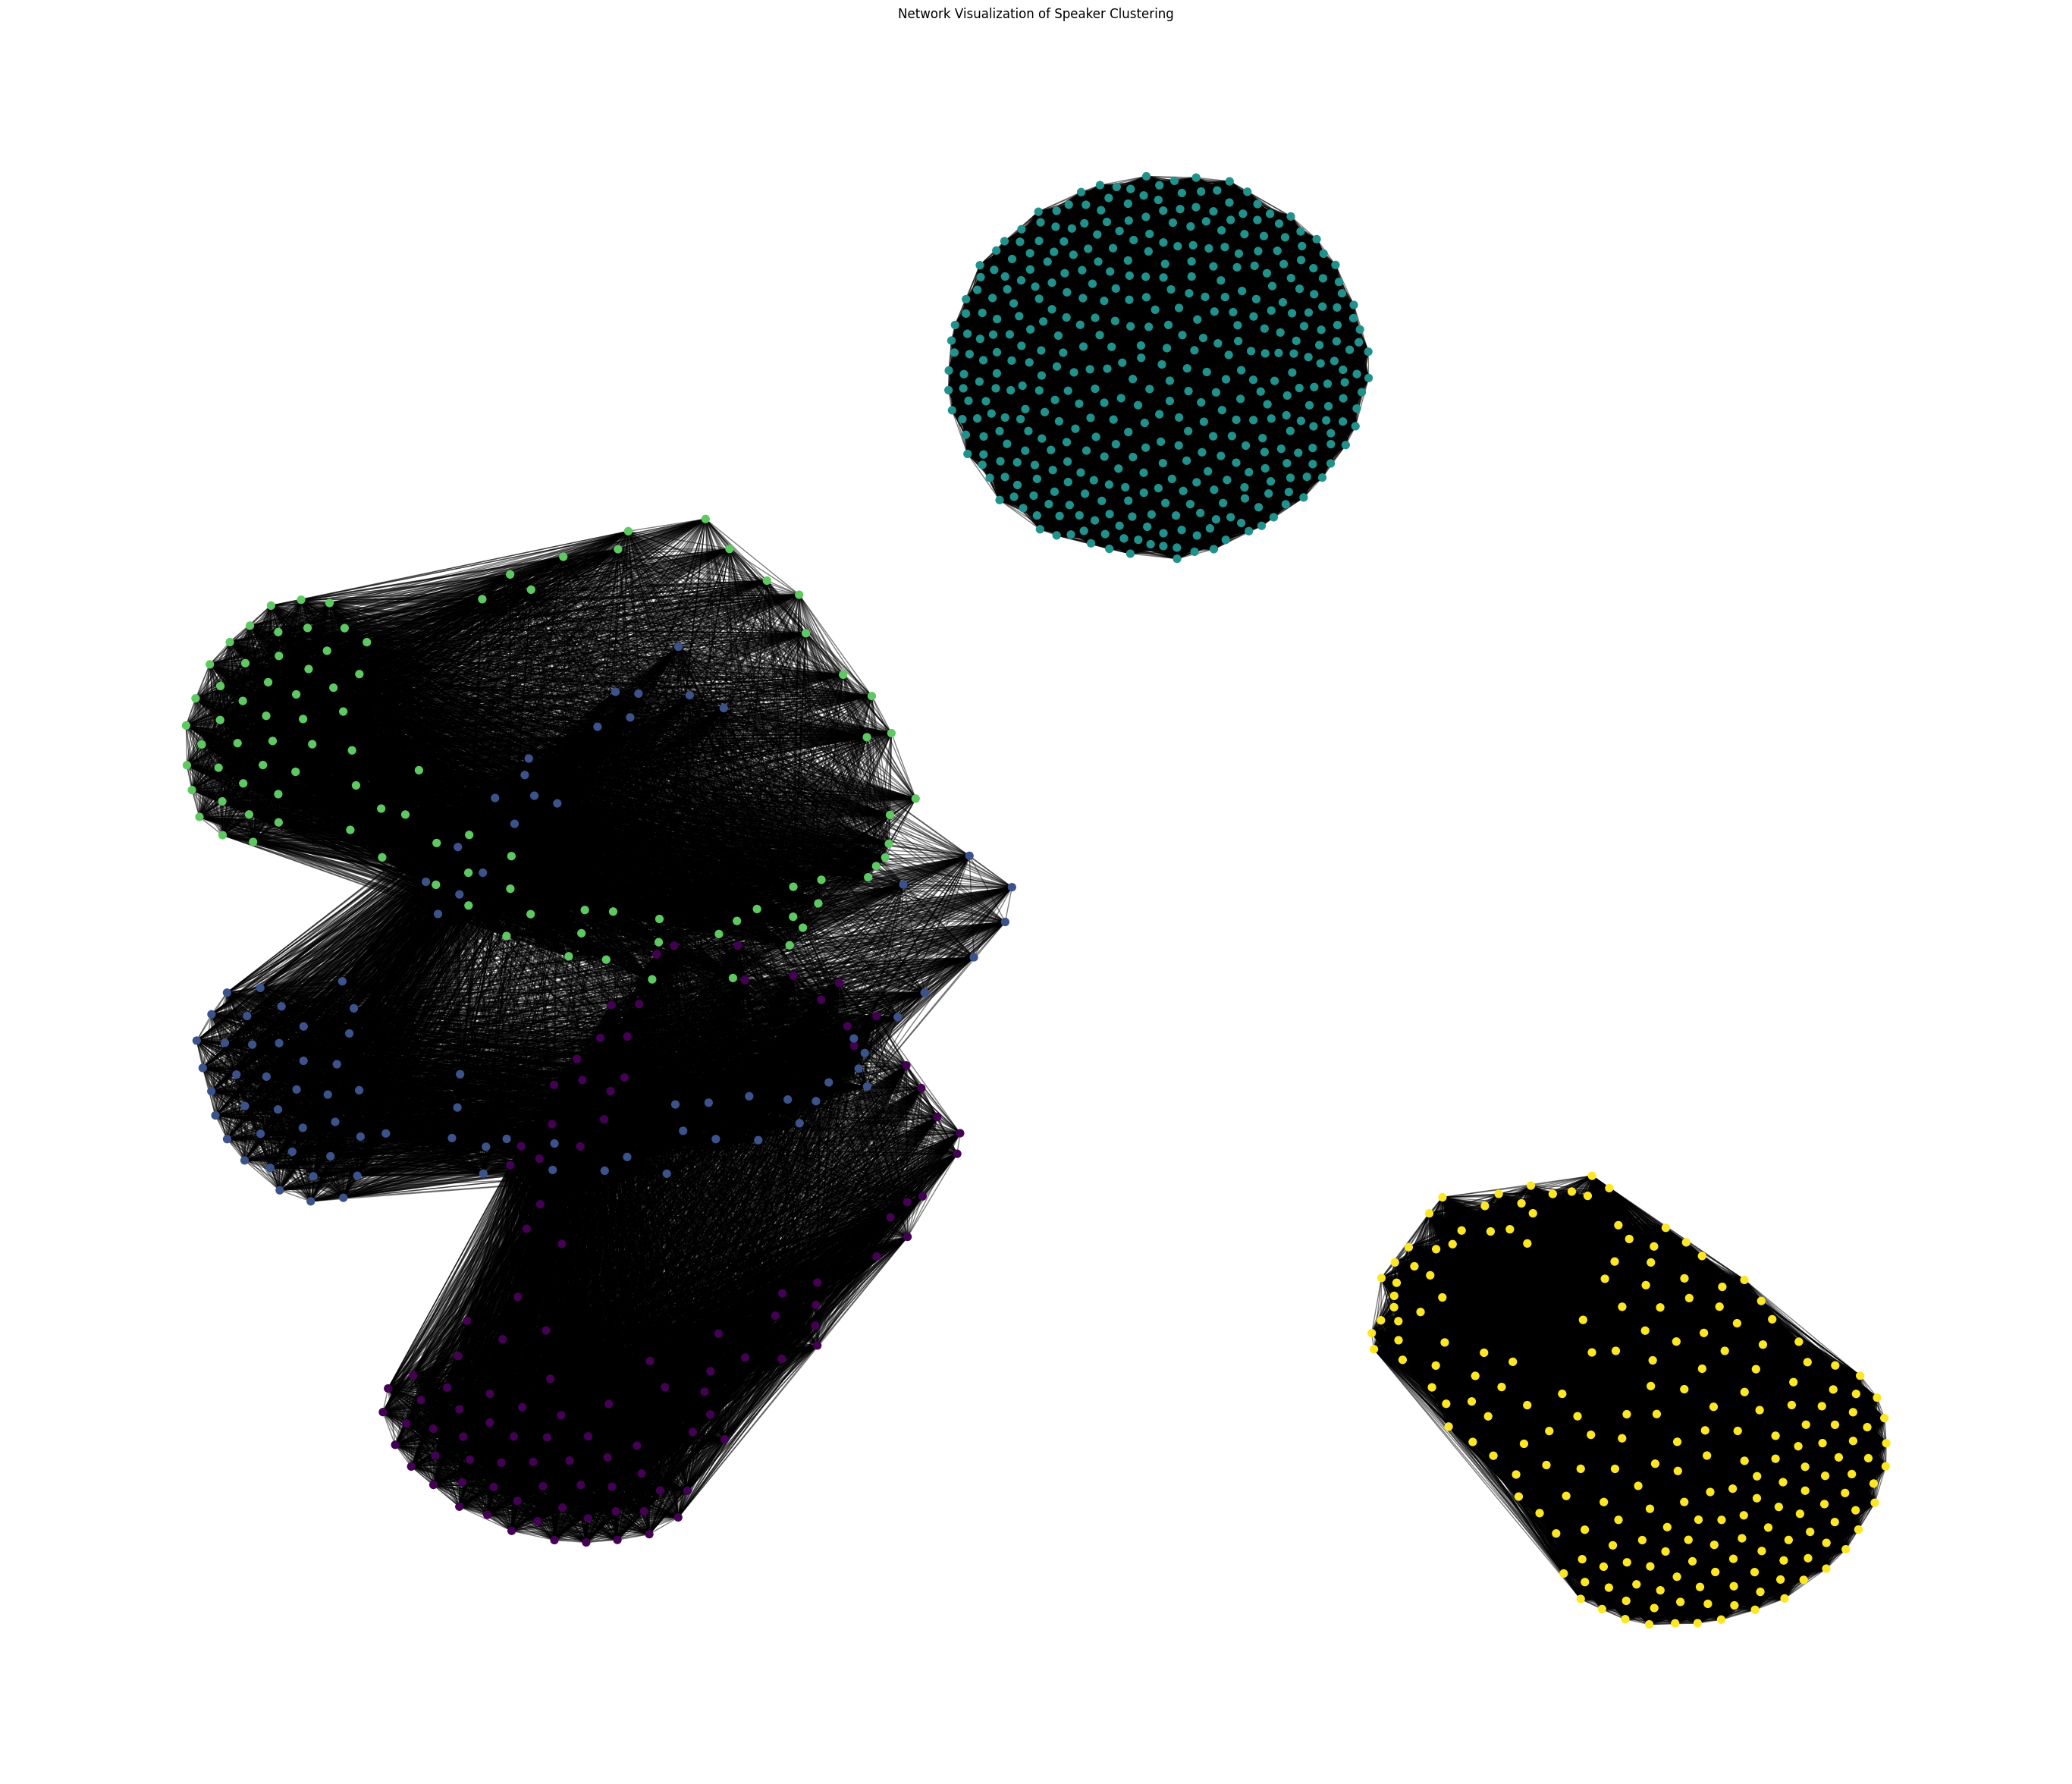

In [55]:
# Create a network graph
G = nx.Graph()

# Add nodes for each document with cluster label as node attribute
for index, row in df_updated.iterrows():
    G.add_node(index, cluster_label=row['cluster_label'])

# Add edges between documents belonging to the same cluster
for cluster_id in range(n_clusters):
    cluster_data = df_updated[df_updated['cluster_label'] == cluster_id]
    for i, row1 in cluster_data.iterrows():
        for j, row2 in cluster_data.iterrows():
            if i != j:
                G.add_edge(i, j)

# Draw the network graph
plt.figure(figsize=(35, 30))
pos = nx.spring_layout(G, k=0.65) 
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.viridis, node_color=cluster_labels)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Network Visualization of Speaker Clustering')
plt.axis('off')
plt.show()